In [19]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/'My Drive'/'All_Repos'/Self-Driving-Car-NanoDegree/CarND-Traffic-Sign-Classifier-Project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Traffic-Sign-Classifier-Project


In [0]:
!ls dataset

signnames.csv	      test.p		      train.p
signnames.csv.gsheet  traffic-signs-data.zip  valid.p


## Load the Data

In [0]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [8]:
import numpy as np


### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_validation = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


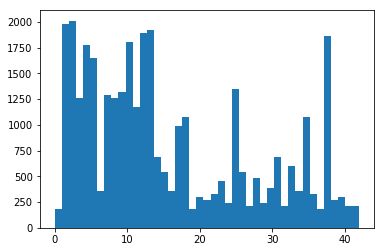

[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]


In [9]:
import matplotlib.pyplot as plt
plt.hist(y_train,bins=43)
plt.show()

uniques,counts = np.unique(y_train,return_counts=True)

print(counts)

In [10]:
import multiprocessing as mp
mp.cpu_count()

2

## Exploratory Visualization

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

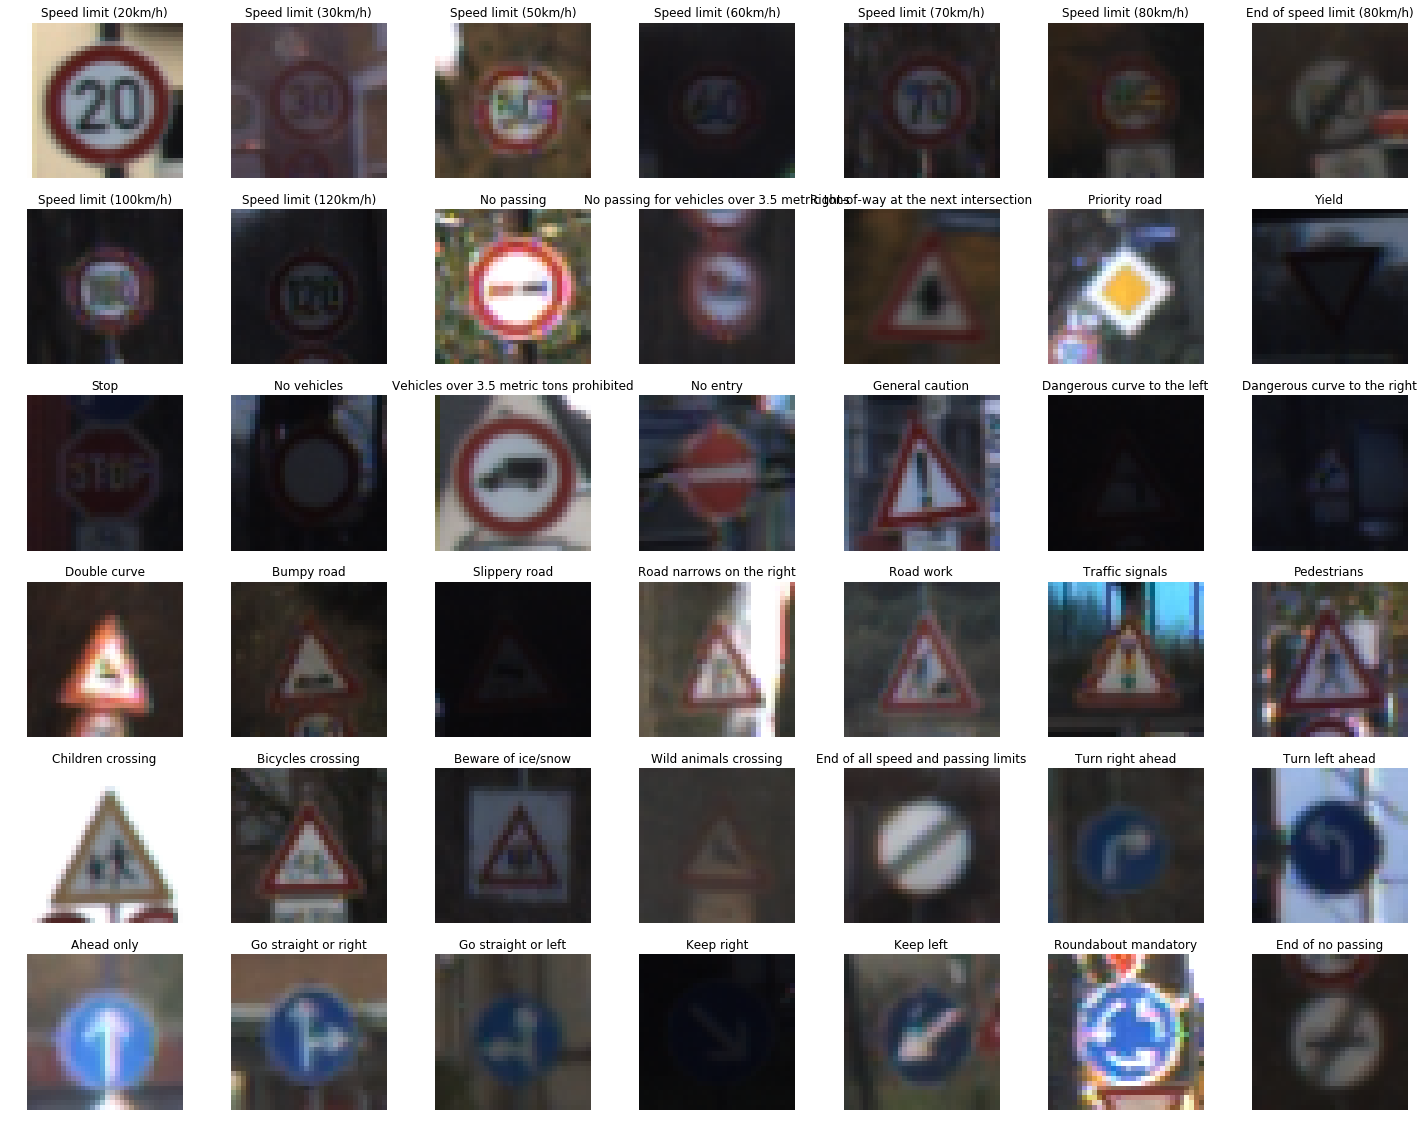

In [11]:
import pandas as pd



names = pd.read_csv('dataset/signnames.csv')
names.set_index(['ClassId'],inplace=True)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 7, figsize=(25, 20))
count = 0

for i in range(6):
  for j in range(7):
    axs[i][j].imshow(X_train[np.where(y_train == count)[0][0]])
    #print(names.loc[5].SignName)
    axs[i][j].set_title(names.loc[count].SignName)
    axs[i][j].set_axis_off()
    count+=1

plt.show()

## Preprocess Data

In [12]:

import random
import tensorflow as tf
from sklearn.utils import shuffle
import cv2
import time
import sys

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
  
  
def transforms(X_train,y_train):
  
  images,labels = X_train,y_train
  
  for i,img in enumerate(images):
    
    uniques_new,counts_new = np.unique(labels,return_counts=True)

    #print(counts_new[labels[i]])
    if counts_new[labels[i]] < 800:
      # Image Brightness
      brit_img = augment_brightness_camera_images(img).reshape(1,32,32,3)
      
      #Translation
      translation_matrix = np.float32([ [1,0,random.randint(0,5)], [0,1,random.randint(0,5)] ])
      img_translate = cv2.warpAffine(img, translation_matrix, (32, 32))      
      img_translate = img_translate.reshape(1,32,32,3)
      
      # Shear
      pts1 = np.float32([[5,5],[20,5],[5,20]])

      pt1 = 5+10*np.random.uniform()-10/2
      pt2 = 20+10*np.random.uniform()-10/2
      
      pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
      
      shear_M = cv2.getAffineTransform(pts1,pts2)     
      img_shear = cv2.warpAffine(img, shear_M, (32, 32)).reshape(1,32,32,3)
      
      #Rotation
      rotation_matrix = cv2.getRotationMatrix2D((16,16),random.randint(0,20),1)
      img_rotate = cv2.warpAffine(img, rotation_matrix, (32, 32))
      img_rotate = img_rotate.reshape(1,32,32,3)
      
      images = np.concatenate((images,np.array(brit_img)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)
      images = np.concatenate((images,np.array(img_translate)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)
      images = np.concatenate((images,np.array(img_rotate)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)
      images = np.concatenate((images,np.array(img_shear)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)      
  
  return images,labels
      
time0 = time.time()
print(X_train.shape)
X_train_new,y_train_new = transforms(X_train,y_train)
time1 = time.time()
elapsed = time1-time0
print(elapsed)
print(X_train_new.shape)





(34799, 32, 32, 3)
464.0905246734619
(46507, 32, 32, 3)


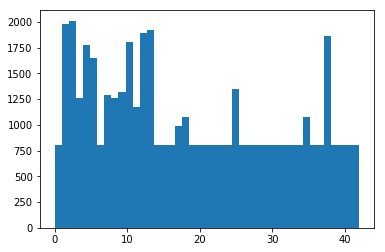

In [14]:
plt.hist(y_train_new,bins=43)
plt.show()

In [0]:
#aug_data = {'X_train':X_train_new, 'y_train':y_train_new}
aug_data_file = 'dataset/augmented_train.p'
with open(aug_data_file, mode='rb') as f:
    train = pickle.load(f)

## Augmented Data


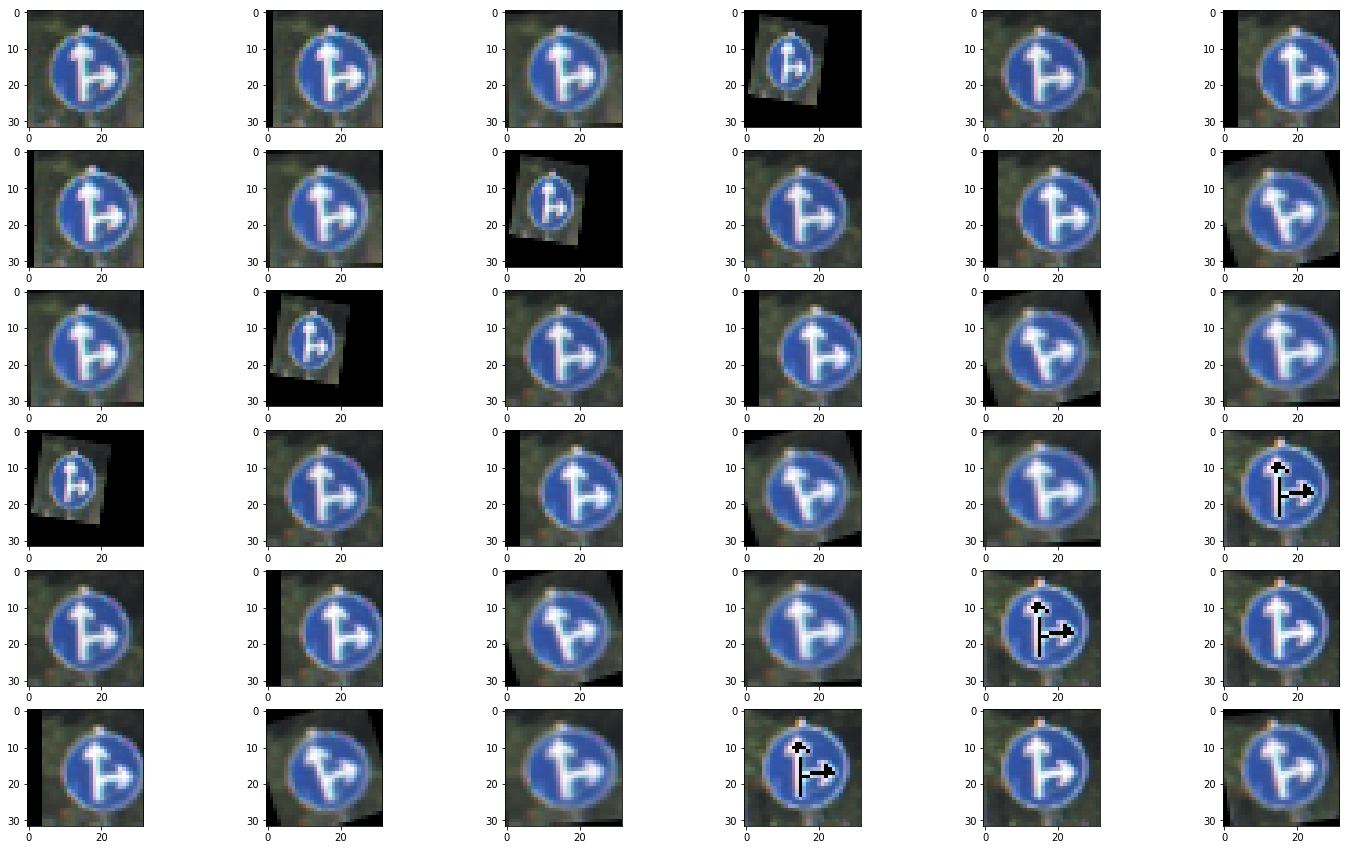

In [28]:
X_train = train['X_train']
fig,axs = plt.subplots(6,6,figsize=(25,15))
for i in range(6):
  for j in range(6):
    axs[i][j].imshow(X_train[35799+(i+j)])
    
plt.show()
    
  